In [9]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [10]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject","day"])

In [18]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_


def cluster_DBSCAN(x):
    db = DBSCAN(metric='euclidean', eps=0.3)
    db.fit(x)
    return db.labels_


def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(x)
    return kmeans.labels_

In [19]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [20]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

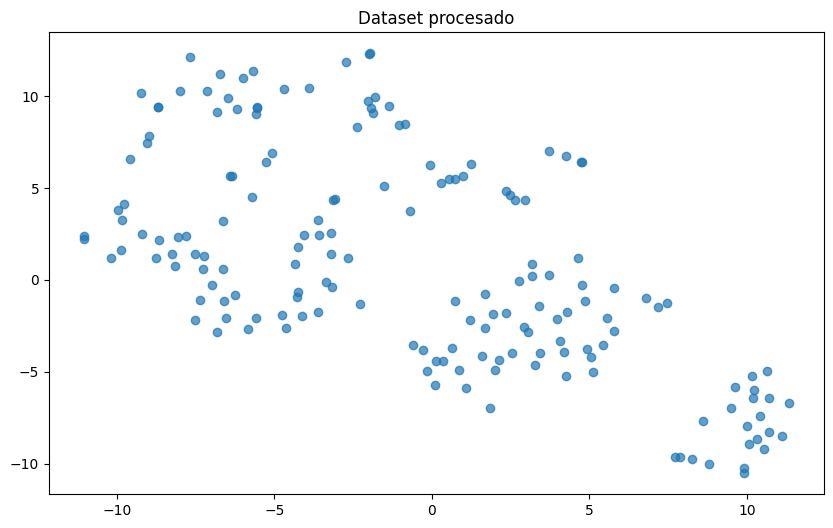

In [21]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=2, how='tsne')

# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

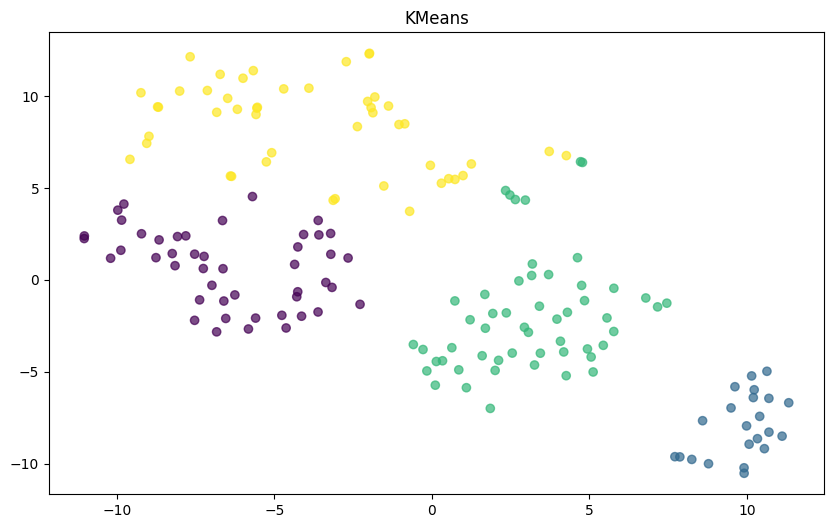

In [22]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=4)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=kmeans_labels, alpha=0.7)
plt.title('KMeans')
plt.show()

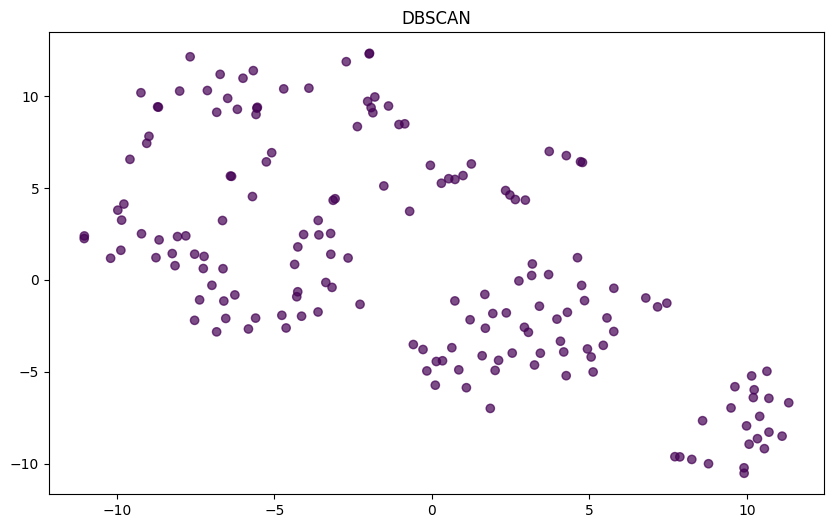

In [23]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=dbscan_labels, alpha=0.7)
plt.title('DBSCAN')
plt.show()

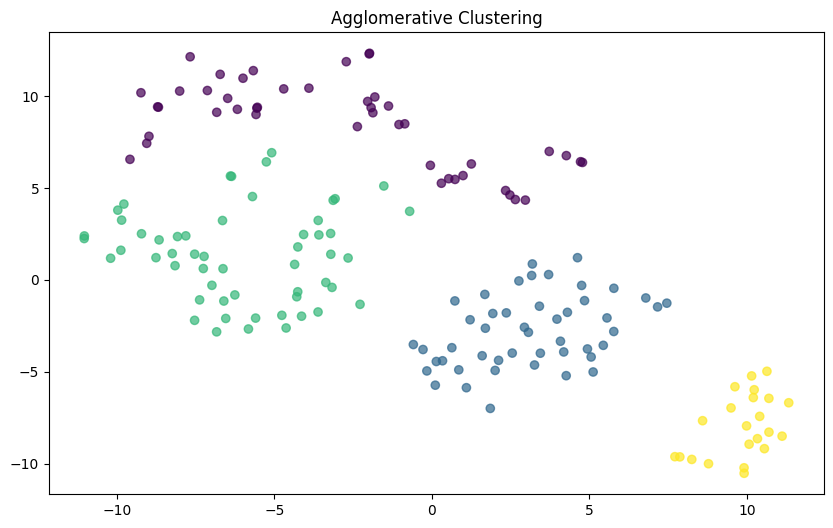

In [24]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=4)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=agglomerative_labels, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.show()